In [59]:
import copy
import time
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import preprocessing
    

pd.set_option('mode.chained_assignment', None)

# max iterator while resacling cluster profiles
MAX_ITERATOR = 20

# tolerance while rescaling cluster periods to meet the annual sum of the original profile
TOLERANCE = 1e-6


# minimal weight that overwrites a weighting of zero in order to carry the profile through the aggregation process
MIN_WEIGHT = 1e-6

def unstackToPeriods(timeSeries, timeStepsPerPeriod):
    """
    Extend the timeseries to an integer multiple of the period length and
    groups the time series to the periods.
    :param timeSeries:
    :type timeSeries: pandas DataFrame
    :param timeStepsPerPeriod: The number of discrete timesteps which describe one period. required
    :type timeStepsPerPeriod: integer
    :returns: - **unstackedTimeSeries** (pandas DataFrame) -- is stacked such that each row represents a
                candidate period
              - **timeIndex** (pandas Series index) -- is the modification of the original
                timeseriesindex in case an integer multiple was created
    """
    # init new grouped timeindex
    unstackedTimeSeries = timeSeries.copy()

    # initialize new indices
    periodIndex = []
    stepIndex = []

    # extend to inger multiple of period length
    if len(timeSeries) % timeStepsPerPeriod == 0:
        attached_timesteps = 0
    else:
        # calculate number of timesteps which get attached
        attached_timesteps = timeStepsPerPeriod - \
                             len(timeSeries) % timeStepsPerPeriod

        # take these from the head of the original time series
        rep_data = unstackedTimeSeries.head(attached_timesteps)

        # append them at the end of the time series
        unstackedTimeSeries = unstackedTimeSeries.append(rep_data,
                                                         ignore_index=False)

    # create period and step index
    for ii in range(0, len(unstackedTimeSeries)):
        periodIndex.append(int(ii / timeStepsPerPeriod))
        stepIndex.append(
            ii - int(ii / timeStepsPerPeriod) * timeStepsPerPeriod)

    # save old index
    timeIndex = copy.deepcopy(unstackedTimeSeries.index)

    # create new double index and unstack the time series
    unstackedTimeSeries.index = pd.MultiIndex.from_arrays([stepIndex,
                                                           periodIndex],
                                                          names=['TimeStep',
                                                                 'PeriodNum'])
    unstackedTimeSeries = unstackedTimeSeries.unstack(level='TimeStep')

    return unstackedTimeSeries, timeIndex


def aggregatePeriods(candidates, n_clusters=8,
                     n_iter=100, clusterMethod='k_means', solver='glpk', ):
    '''
    Clusters the data based on one of the cluster methods:
        'averaging','k_means','exact k_medoid' or 'hierarchical'
    :param candidates: Dissimilarity matrix where each row represents a candidate. required
    :type candidates: np.ndarray
    :param n_clusters: Number of aggregated cluster. optional (default: 8)
    :type n_clusters: integer
    :param n_iter: Only required for the number of starts of the k-mean algorithm. optional (default: 10)
    :type n_iter: integer
    :param clusterMethod: Chosen clustering algorithm. Possible values are
        'averaging','k_means','exact k_medoid' or 'hierarchical'. optional (default: 'k_means')
    :type clusterMethod: string
    '''

    clusterCenterIndices = None

    # cluster the data
    if clusterMethod == 'averaging':
        n_sets = len(candidates)
        if n_sets % n_clusters == 0:
            cluster_size = int(n_sets / n_clusters)
            clusterOrder = [
                [n_cluster] *
                cluster_size for n_cluster in range(n_clusters)]
        else:
            cluster_size = int(n_sets / n_clusters)
            clusterOrder = [
                [n_cluster] *
                cluster_size for n_cluster in range(n_clusters)]
            clusterOrder.append([n_clusters - 1] *
                                int(n_sets - cluster_size * n_clusters))
        clusterOrder = np.hstack(np.array(clusterOrder))
        clusterCenters = meanRepresentation(candidates, clusterOrder)

    if clusterMethod == 'k_means':
        from sklearn.cluster import KMeans
        k_means = KMeans(
            n_clusters=n_clusters,
            max_iter=1000,
            n_init=n_iter,
            tol=1e-4)

        clusterOrder = k_means.fit_predict(candidates)
        # get with own mean representation to avoid numerical trouble caused by sklearn
        clusterCenters = meanRepresentation(candidates, clusterOrder)

    elif clusterMethod == 'k_medoids':
        from tsam.utils.k_medoids_exact import KMedoids
        k_medoid = KMedoids(n_clusters=n_clusters, solver=solver)

        clusterOrder = k_medoid.fit_predict(candidates)
        clusterCenters = k_medoid.cluster_centers_

    elif clusterMethod == 'hierarchical':
        if n_clusters==1:
            clusterOrder=np.asarray([0]*len(candidates))
        else:
            from sklearn.cluster import AgglomerativeClustering
            clustering = AgglomerativeClustering(
                n_clusters=n_clusters, linkage='ward')
            clusterOrder = clustering.fit_predict(candidates)
        # represent hierarchical aggregation with medoid
        clusterCenters, clusterCenterIndices = medoidRepresentation(candidates, clusterOrder)

    return clusterCenters, clusterCenterIndices, clusterOrder


def medoidRepresentation(candidates, clusterOrder):
    '''
    Represents the candidates of a given cluster group (clusterOrder)
    by its medoid, measured with the euclidean distance.
    :param candidates: Dissimilarity matrix where each row represents a candidate. required
    :type candidates: np.ndarray
    :param clusterOrder: Integer array where the index refers to the candidate and the
        Integer entry to the group. required
    :type clusterOrder: np.array
    '''
    # set cluster center as medoid
    clusterCenters = []
    clusterCenterIndices = []
    for clusterNum in np.unique(clusterOrder):
        indice = np.where(clusterOrder == clusterNum)
        innerDistMatrix = euclidean_distances(candidates[indice])
        mindistIdx = np.argmin(innerDistMatrix.sum(axis=0))
        clusterCenters.append(candidates[indice][mindistIdx])
        clusterCenterIndices.append(indice[0][mindistIdx])

    return clusterCenters, clusterCenterIndices


def meanRepresentation(candidates, clusterOrder):
    '''
    Represents the candidates of a given cluster group (clusterOrder)
    by its mean.
    :param candidates: Dissimilarity matrix where each row represents a candidate. required
    :type candidates: np.ndarray
    :param clusterOrder: Integer array where the index refers to the candidate and the
        Integer entry to the group. required
    :type clusterOrder: np.array
    '''
    # set cluster centers as means of the group candidates
    clusterCenters = []
    for clusterNum in np.unique(clusterOrder):
        indice = np.where(clusterOrder == clusterNum)
        currentMean = candidates[indice].mean(axis=0)
        clusterCenters.append(currentMean)
    return clusterCenters


class TimeSeriesAggregation(object):
    '''
    Clusters time series data to typical periods.
    '''
    CLUSTER_METHODS = ['averaging', 'k_medoids', 'k_means', 'hierarchical']

    EXTREME_PERIOD_METHODS = [
        'None',
        'append',
        'new_cluster_center',
        'replace_cluster_center']

    def __init__(self, timeSeries, resolution=None, noTypicalPeriods=10,
                 noSegments=10, hoursPerPeriod=24, clusterMethod='hierarchical',
                 evalSumPeriods=False, sortValues=False, sameMean=False,
                 rescaleClusterPeriods=True, weightDict=None, segmentation = False,
                 extremePeriodMethod='None', predefClusterOrder=None,
                 predefClusterCenterIndices=None, solver='glpk',
                 roundOutput = None,
                 addPeakMin=None,
                 addPeakMax=None,
                 addMeanMin=None,
                 addMeanMax=None):
        '''
        Initialize the periodly clusters.
        :param timeSeries: DataFrame with the datetime as index and the relevant
            time series parameters as columns. required
        :type timeSeries: pandas.DataFrame() or dict
        :param resolution: Resolution of the time series in hours [h]. If timeSeries is a
            pandas.DataFrame() the resolution is derived from the datetime
            index. optional, default: delta_T in timeSeries
        :type resolution: float
        :param hoursPerPeriod: Value which defines the length of a cluster period. optional, default: 24
        :type hoursPerPeriod: integer
        :param noTypicalPeriods: Number of typical Periods - equivalent to the number of clusters. optional, default: 10
        :type noTypicalPeriods: integer
        :param noSegments: Number of segments in which the typical periods shoul be subdivided - equivalent to the
            number of inner-period clusters. optional, default: 10
        :type noSegments: integer
        :param clusterMethod: Chosen clustering method. optional, default: 'hierarchical'
            |br| Options are:
            * 'averaging'
            * 'k_means'
            * 'k_medoids'
            * 'hierarchical'
        :type clusterMethod: string
        :param evalSumPeriods: Boolean if in the clustering process also the averaged periodly values
            shall be integrated additional to the periodly profiles as parameters. optional, default: False
        :type evalSumPeriods: boolean
        :param sameMean: Boolean which is used in the normalization procedure. If true, all time series get normalized
            such that they have the same mean value. optional, default: False
        :type sameMean: boolean
        :param sortValues: Boolean if the clustering should be done by the periodly duration
            curves (true) or the original shape of the data. optional (default: False)
        :type sortValues: boolean
        :param rescaleClusterPeriods: Decides if the cluster Periods shall get rescaled such that their
            weighted mean value fits the mean value of the original time series. optional (default: True)
        :type rescaleClusterPeriods: boolean
        :param weightDict: Dictionary which weights the profiles. It is done by scaling
            the time series while the normalization process. Normally all time
            series have a scale from 0 to 1. By scaling them, the values get
            different distances to each other and with this, they are
            differently evaluated while the clustering process. optional (default: None )
        :type weightDict: dict
        :param extremePeriodMethod: Method how to integrate extreme Periods (peak demand, lowest temperature etc.)
            into to the typical period profiles. optional, default: 'None'
            |br| Options are:
            * None: No integration at all.
            * 'append': append typical Periods to cluster centers
            * 'new_cluster_center': add the extreme period as additional cluster center. It is checked then for all
              Periods if they fit better to the this new center or their original cluster center.
            * 'replace_cluster_center': replaces the cluster center of the
              cluster where the extreme period belongs to with the periodly profile of the extreme period. (Worst
              case system design)
        :type extremePeriodMethod: string
        :param predefClusterOrder: Instead of aggregating a time series, a predefined grouping is taken
            which is given by this list. optional (default: None)
        :type predefClusterOrder: list or array
        :param predefClusterCenterIndices: If predefClusterOrder is give, this list can define the representative
            cluster candidates. Otherwise the medoid is taken. optional (default: None)
        :type predefClusterCenterIndices: list or array
        :param solver: Solver that is used for k_medoids clustering. optional (default: 'glpk' )
        :type solver: string
        :param roundOutput: Decimals to what the output time series get round. optional (default: None )
        :type roundOutput: integer
        :param addPeakMin: List of column names which's minimal value shall be added to the
            typical periods. E.g.: ['Temperature']. optional, default: []
        :type addPeakMin: list
        :param addPeakMax: List of column names which's maximal value shall be added to the
            typical periods. E.g. ['EDemand', 'HDemand']. optional, default: []
        :type addPeakMax: list
        :param addMeanMin: List of column names where the period with the cumulative minimal value
            shall be added to the typical periods. E.g. ['Photovoltaic']. optional, default: []
        :type addMeanMin: list
        :param addMeanMax: List of column names where the period with the cumulative maximal value
            shall be added to the typical periods. optional, default: []
        :type addMeanMax: list
        '''
        if addMeanMin is None:
            addMeanMin = []
        if addMeanMax is None:
            addMeanMax = []
        if addPeakMax is None:
            addPeakMax = []
        if addPeakMin is None:
            addPeakMin = []
        if weightDict is None:
            weightDict = {}
        self.timeSeries = timeSeries

        self.resolution = resolution

        self.hoursPerPeriod = hoursPerPeriod

        self.noTypicalPeriods = noTypicalPeriods

        self.noSegments = noSegments

        self.clusterMethod = clusterMethod

        self.extremePeriodMethod = extremePeriodMethod

        self.evalSumPeriods = evalSumPeriods

        self.sortValues = sortValues

        self.sameMean = sameMean

        self.rescaleClusterPeriods = rescaleClusterPeriods

        self.weightDict = weightDict

        self.predefClusterOrder = predefClusterOrder

        self.predefClusterCenterIndices = predefClusterCenterIndices

        self.solver = solver

        self.segmentation = segmentation

        self.roundOutput = roundOutput

        self.addPeakMin = addPeakMin

        self.addPeakMax = addPeakMax

        self.addMeanMin = addMeanMin

        self.addMeanMax = addMeanMax

        self._check_init_args()

        # internal attributes 
        self._normalizedMean = None

        return

    def _check_init_args(self):

        # check timeSeries and set it as pandas DataFrame
        if not isinstance(self.timeSeries, pd.DataFrame):
            if isinstance(self.timeSeries, dict):
                self.timeSeries = pd.DataFrame(self.timeSeries)
            elif isinstance(self.timeSeries, np.ndarray):
                self.timeSeries = pd.DataFrame(self.timeSeries)
            else:
                raise ValueError('timeSeries has to be of type pandas.DataFrame() ' +
                                 'or of type np.array() '
                                 'in initialization of object of class ' +
                                 type(self).__name__)

        # check if extreme periods exist in the dataframe
        for peak in self.addPeakMin:
            if peak not in self.timeSeries.columns:
                raise ValueError(peak + ' listed in "addPeakMin"' +
                                 ' does not occure as timeSeries column')
        for peak in self.addPeakMax:
            if peak not in self.timeSeries.columns:
                raise ValueError(peak + ' listed in "addPeakMax"' +
                                 ' does not occure as timeSeries column')
        for peak in self.addMeanMin:
            if peak not in self.timeSeries.columns:
                raise ValueError(peak + ' listed in "addMeanMin"' +
                                 ' does not occure as timeSeries column')
        for peak in self.addMeanMax:
            if peak not in self.timeSeries.columns:
                raise ValueError(peak + ' listed in "addMeanMax"' +
                                 ' does not occure as timeSeries column')

        # derive resolution from date time index if not provided
        if self.resolution is None:
            try:
                timedelta = self.timeSeries.index[1] - self.timeSeries.index[0]
                self.resolution = float(timedelta.total_seconds()) / 3600
            except TypeError:
                try:
                    self.timeSeries.index = pd.to_datetime(self.timeSeries.index)
                    timedelta = self.timeSeries.index[1] - self.timeSeries.index[0]
                    self.resolution = float(timedelta.total_seconds()) / 3600
                except:
                    ValueError("'resolution' argument has to be nonnegative float or int" +
                               " or the given timeseries needs a datetime index")

        if not (isinstance(self.resolution, int) or isinstance(self.resolution, float)):
            raise ValueError("resolution has to be nonnegative float or int")

        # check hoursPerPeriod
        if self.hoursPerPeriod is None or self.hoursPerPeriod <= 0 or \
                not isinstance(self.hoursPerPeriod, int):
            raise ValueError("hoursPerPeriod has to be nonnegative integer")

        # check typical Periods
        if self.noTypicalPeriods is None or self.noTypicalPeriods <= 0 or \
                not isinstance(self.noTypicalPeriods, int):
            raise ValueError("noTypicalPeriods has to be nonnegative integer")
        self.timeStepsPerPeriod = int(self.hoursPerPeriod / self.resolution)
        if not self.timeStepsPerPeriod == self.hoursPerPeriod / self.resolution:
            raise ValueError('The combination of hoursPerPeriod and the '
                             + 'resulution does not result in an integer '
                             + 'number of time steps per period')
        if self.segmentation:
            if self.noSegments > self.timeStepsPerPeriod:
                warnings.warn("The number of segments must be less than or equal to the number of time steps per period. "
                              "Segment number is decreased to number of time steps per period.")
                self.noSegments = self.timeStepsPerPeriod

        # check clusterMethod
        if self.clusterMethod not in self.CLUSTER_METHODS:
            raise ValueError("clusterMethod needs to be one of " +
                             "the following: " +
                             "{}".format(self.CLUSTER_METHODS))

        # check extremePeriods
        if self.extremePeriodMethod not in self.EXTREME_PERIOD_METHODS:
            raise ValueError("extremePeriodMethod needs to be one of " +
                             "the following: " +
                             "{}".format(self.EXTREME_PERIOD_METHODS))

        # check evalSumPeriods
        if not isinstance(self.evalSumPeriods, bool):
            raise ValueError("evalSumPeriods has to be boolean")
        # check sortValues
        if not isinstance(self.sortValues, bool):
            raise ValueError("sortValues has to be boolean")
        # check sameMean
        if not isinstance(self.sameMean, bool):
            raise ValueError("sameMean has to be boolean")
        # check rescaleClusterPeriods
        if not isinstance(self.rescaleClusterPeriods, bool):
            raise ValueError("rescaleClusterPeriods has to be boolean")

        # check predefClusterOrder
        if self.predefClusterOrder is not None:
            if not isinstance(self.predefClusterOrder, (list, np.ndarray)):
                raise ValueError("predefClusterOrder has to be an array or list")
            if self.predefClusterCenterIndices is not None:
                # check predefClusterCenterIndices
                if not isinstance(self.predefClusterCenterIndices, (list, np.ndarray)):
                    raise ValueError("predefClusterCenterIndices has to be an array or list")
        elif self.predefClusterCenterIndices is not None:
            raise ValueError('If "predefClusterCenterIndices" is defined, "predefClusterOrder" needs to be defined as well')

        return

    def _normalizeTimeSeries(self, sameMean=False):
        '''
        Normalizes each time series independently.
        :param sameMean: Decides if the time series should have all the same mean value.
            Relevant for weighting time series. optional (default: False)
        :type sameMean: boolean
        :returns: normalized time series
        '''
        min_max_scaler = preprocessing.MinMaxScaler()
        normalizedTimeSeries = pd.DataFrame(min_max_scaler.fit_transform(self.timeSeries),
                                            columns=self.timeSeries.columns,
                                            index=self.timeSeries.index)
        
        self._normalizedMean = normalizedTimeSeries.mean()
        if sameMean:
            normalizedTimeSeries /= self._normalizedMean

        return normalizedTimeSeries

    def _unnormalizeTimeSeries(self, normalizedTimeSeries, sameMean=False):
        '''
        Equivalent to '_normalizeTimeSeries'. Just does the back
        transformation.
        :param normalizedTimeSeries: Time series which should get back transformated. required
        :type normalizedTimeSeries: pandas.DataFrame()
        :param sameMean: Has to have the same value as in _normalizeTimeSeries. optional (default: False)
        :type sameMean: boolean
        :returns: unnormalized time series
        '''
        from sklearn import preprocessing
        min_max_scaler = preprocessing.MinMaxScaler()
        min_max_scaler.fit(self.timeSeries)

        if sameMean:
            normalizedTimeSeries *= self._normalizedMean

        unnormalizedTimeSeries = pd.DataFrame(min_max_scaler.inverse_transform(
            normalizedTimeSeries),
            columns=normalizedTimeSeries.columns,
            index=normalizedTimeSeries.index)

        return unnormalizedTimeSeries

    def _preProcessTimeSeries(self):
        '''
        Normalize the time series, weight them based on the weight dict and
        puts them into the correct matrix format.
        '''
        # first sort the time series in order to avoid bug mention in #18
        self.timeSeries.sort_index(axis=1, inplace=True)

        # convert the dataframe to floats
        self.timeSeries = self.timeSeries.astype(float)

        # normalize the time series and group them to periodly profiles
        self.normalizedTimeSeries = self._normalizeTimeSeries(
            sameMean=self.sameMean)

        for column in self.weightDict:
            if self.weightDict[column] < MIN_WEIGHT:
                print('weight of "'+ str(column) + '" set to the minmal tolerable weighting')
                self.weightDict[column] = MIN_WEIGHT
            self.normalizedTimeSeries[column] = self.normalizedTimeSeries[
                                                    column] * self.weightDict[column]

        self.normalizedPeriodlyProfiles, self.timeIndex = unstackToPeriods(
            self.normalizedTimeSeries, self.timeStepsPerPeriod)

        # check if no NaN is in the resulting profiles
        if self.normalizedPeriodlyProfiles.isnull().values.any():
            raise ValueError(
                'Pre processed data includes NaN. Please check the timeSeries input data.')

    def _postProcessTimeSeries(self, normalizedTimeSeries):
        '''
        Neutralizes the weighting the time series back and unnormalizes them.
        '''
        for column in self.weightDict:
            normalizedTimeSeries[column] = normalizedTimeSeries[
                                                column] / self.weightDict[column]

        unnormalizedTimeSeries = self._unnormalizeTimeSeries(
            normalizedTimeSeries, sameMean=self.sameMean)

        if self.roundOutput is not None:
            unnormalizedTimeSeries = unnormalizedTimeSeries.round(decimals = self.roundOutput)

        return unnormalizedTimeSeries

    def _addExtremePeriods(self, groupedSeries, clusterCenters,
                           clusterOrder,
                           extremePeriodMethod='new_cluster_center',
                           addPeakMin=None,
                           addPeakMax=None,
                           addMeanMin=None,
                           addMeanMax=None):
        '''
        Adds different extreme periods based on the to the clustered data,
        decribed by the clusterCenters and clusterOrder.
        :param groupedSeries: periodly grouped groupedSeries on which basis it should be decided,
            which period is an extreme period. required
        :type groupedSeries: pandas.DataFrame()
        :param clusterCenters: Output from clustering with sklearn. required
        :type clusterCenters: dict
        :param clusterOrder: Output from clsutering with sklearn. required
        :type clusterOrder: dict
        :param extremePeriodMethod: Chosen extremePeriodMethod. The method. optional(default: 'new_cluster_center' )
        :type extremePeriodMethod: string
        :returns: - **newClusterCenters** -- The new cluster centers extended with the extreme periods.
                  - **newClusterOrder** -- The new cluster order including the extreme periods.
                  - **extremeClusterIdx** -- A list of indices where in the newClusterCenters are the extreme
                    periods located.
        '''

        # init required dicts and lists
        if addPeakMin is None:
            addPeakMin = []
        if addPeakMax is None:
            addPeakMax = []
        if addMeanMin is None:
            addMeanMin = []
        if addMeanMax is None:
            addMeanMax = []
        self.extremePeriods = {}
        extremePeriodNo = []

        ccList = [center.tolist() for center in clusterCenters]

        # check which extreme periods exist in the profile and add them to
        # self.extremePeriods dict
        for column in self.timeSeries.columns:

            if column in addPeakMax:
                stepNo = groupedSeries[column].max(axis=1).idxmax()
                # add only if stepNo is not already in extremePeriods
                # if it is not already a cluster center
                if stepNo not in extremePeriodNo and groupedSeries.loc[stepNo,:].values.tolist() not in ccList:
                    max_col = self._append_col_with(column, ' max.')
                    self.extremePeriods[max_col] = \
                        {'stepNo': stepNo,
                         'profile': groupedSeries.loc[stepNo,:].values,
                         'column': column}
                    extremePeriodNo.append(stepNo)

            if column in addPeakMin:
                stepNo = groupedSeries[column].min(axis=1).idxmin()
                # add only if stepNo is not already in extremePeriods
                # if it is not already a cluster center
                if stepNo not in extremePeriodNo and groupedSeries.loc[stepNo,:].values.tolist() not in ccList:
                    min_col = self._append_col_with(column, ' min.')
                    self.extremePeriods[min_col] = \
                        {'stepNo': stepNo,
                         'profile': groupedSeries.loc[stepNo,:].values,
                         'column': column}
                    extremePeriodNo.append(stepNo)

            if column in addMeanMax:
                stepNo = groupedSeries[column].mean(axis=1).idxmax()
                # add only if stepNo is not already in extremePeriods
                # if it is not already a cluster center
                if stepNo not in extremePeriodNo and groupedSeries.loc[stepNo,:].values.tolist() not in ccList:
                    mean_max_col = self._append_col_with(column, ' daily max.')
                    self.extremePeriods[mean_max_col] = \
                        {'stepNo': stepNo,
                         'profile': groupedSeries.loc[stepNo,:].values,
                         'column': column}
                    extremePeriodNo.append(stepNo)

            if column in addMeanMin:
                stepNo = groupedSeries[column].mean(axis=1).idxmin()
                # add only if stepNo is not already in extremePeriods and
                # if it is not already a cluster center
                if stepNo not in extremePeriodNo and groupedSeries.loc[stepNo,:].values.tolist() not in ccList:
                    mean_min_col = self._append_col_with(column, ' daily min.')
                    self.extremePeriods[mean_min_col] = \
                        {'stepNo': stepNo,
                         'profile': groupedSeries.loc[stepNo,:].values,
                         'column': column}
                    extremePeriodNo.append(stepNo)

        for periodType in self.extremePeriods:
            # get current related clusters of extreme periods
            self.extremePeriods[periodType]['clusterNo'] = clusterOrder[
                self.extremePeriods[periodType]['stepNo']]

            # init new cluster structure
        newClusterCenters = []
        newClusterOrder = clusterOrder
        extremeClusterIdx = []

        # integrate extreme periods to clusters
        if extremePeriodMethod == 'append':
            # attach extreme periods to cluster centers
            for i, cluster_center in enumerate(clusterCenters):
                newClusterCenters.append(cluster_center)
            for i, periodType in enumerate(self.extremePeriods):
                extremeClusterIdx.append(len(newClusterCenters))
                newClusterCenters.append(
                    self.extremePeriods[periodType]['profile'])
                newClusterOrder[self.extremePeriods[periodType]['stepNo']] = i + len(clusterCenters)

        elif extremePeriodMethod == 'new_cluster_center':
            for i, cluster_center in enumerate(clusterCenters):
                newClusterCenters.append(cluster_center)
            # attach extrem periods to cluster centers and consider for all periods
            # if the fit better to the cluster or the extrem period
            for i, periodType in enumerate(self.extremePeriods):
                extremeClusterIdx.append(len(newClusterCenters))
                newClusterCenters.append(
                    self.extremePeriods[periodType]['profile'])
                self.extremePeriods[periodType][
                    'newClusterNo'] = i + len(clusterCenters)

            for i, cPeriod in enumerate(newClusterOrder):
                # caclulate euclidean distance to cluster center
                cluster_dist = sum(
                    (groupedSeries.iloc[i].values - clusterCenters[cPeriod]) ** 2)
                for ii, extremPeriodType in enumerate(self.extremePeriods):
                    # exclude other extreme periods from adding to the new
                    # cluster center
                    isOtherExtreme = False
                    for otherExPeriod in self.extremePeriods:
                        if (i == self.extremePeriods[otherExPeriod]['stepNo']
                                and otherExPeriod != extremPeriodType):
                            isOtherExtreme = True
                    # calculate distance to extreme periods
                    extperiod_dist = sum(
                        (groupedSeries.iloc[i].values -
                         self.extremePeriods[extremPeriodType]['profile']) ** 2)
                    # choose new cluster relation
                    if extperiod_dist < cluster_dist and not isOtherExtreme:
                        newClusterOrder[i] = self.extremePeriods[
                            extremPeriodType]['newClusterNo']

        elif extremePeriodMethod == 'replace_cluster_center':
            # Worst Case Clusterperiods
            newClusterCenters = clusterCenters
            for periodType in self.extremePeriods:
                index = groupedSeries.columns.get_loc(
                    self.extremePeriods[periodType]['column'])
                newClusterCenters[self.extremePeriods[periodType]['clusterNo']][index] = \
                    self.extremePeriods[periodType]['profile'][index]
                if not self.extremePeriods[periodType]['clusterNo'] in extremeClusterIdx:
                    extremeClusterIdx.append(
                        self.extremePeriods[periodType]['clusterNo'])

        else:
            raise NotImplementedError('Chosen "extremePeriodMethod": ' +
                                      str(extremePeriodMethod) + ' is ' +
                                      'not implemented.')

        return newClusterCenters, newClusterOrder, extremeClusterIdx

    def _append_col_with(self, column, append_with=' max.'):
        """Appends a string to the column name. For MultiIndexes, which turn out to be
        tuples when this method is called, only last level is changed"""
        if isinstance(column, str):
            return column + append_with
        elif isinstance(column, tuple):
            col = list(column)
            col[-1] = col[-1] + append_with
            return tuple(col)

    def _rescaleClusterPeriods(
            self, clusterOrder, clusterPeriods, extremeClusterIdx):
        '''
        Rescale the values of the clustered Periods such that mean of each time
        series in the typical Periods fits the mean value of the original time
        series, without changing the values of the extremePeriods.
        '''
        weightingVec = pd.Series(self._clusterPeriodNoOccur).values
        typicalPeriods = pd.DataFrame(
            clusterPeriods, columns=self.normalizedPeriodlyProfiles.columns)
        idx_wo_peak = np.delete(typicalPeriods.index, extremeClusterIdx)
        for column in self.timeSeries.columns:
            diff = 1
            sum_raw = self.normalizedPeriodlyProfiles[column].sum().sum()
            sum_peak = sum(
                weightingVec[extremeClusterIdx] *
                typicalPeriods[column].loc[extremeClusterIdx,:].sum(
                    axis=1))
            sum_clu_wo_peak = sum(
                weightingVec[idx_wo_peak] *
                typicalPeriods[column].loc[idx_wo_peak,:].sum(
                    axis=1))

            # define the upper scale dependent on the weighting of the series
            scale_ub = 1.0
            if self.sameMean:
                scale_ub = scale_ub * self.timeSeries[column].max(
                ) / self.timeSeries[column].mean()
            if column in self.weightDict:
                scale_ub = scale_ub * self.weightDict[column]

            # difference between predicted and original sum
            diff = abs(sum_raw - (sum_clu_wo_peak + sum_peak))

            # use while loop to rescale cluster periods
            a = 0
            while diff > sum_raw * TOLERANCE and a < MAX_ITERATOR:
                # rescale values
                typicalPeriods.loc[idx_wo_peak, column] = \
                    (typicalPeriods[column].loc[idx_wo_peak,:].values *
                     (sum_raw - sum_peak) / sum_clu_wo_peak)

                # reset values higher than the upper sacle or less than zero
                typicalPeriods[column][
                    typicalPeriods[column] > scale_ub] = scale_ub
                typicalPeriods[column][
                    typicalPeriods[column] < 0.0] = 0.0

                typicalPeriods[column] = typicalPeriods[
                    column].fillna(0.0)

                # calc new sum and new diff to orig data
                sum_clu_wo_peak = sum(
                    weightingVec[idx_wo_peak] *
                    typicalPeriods[column].loc[idx_wo_peak,:].sum(
                        axis=1))
                diff = abs(sum_raw - (sum_clu_wo_peak + sum_peak))
                a += 1
            if a == MAX_ITERATOR:
                deviation = str(round((diff/sum_raw)*100,2))
                warnings.warn(
                    'Max iteration number reached for "'+ str(column)
                    +'" while rescaling the cluster periods.' + 
                    ' The integral of the aggregated time series deviates by: ' 
                    + deviation + '%')
        return typicalPeriods.values

    def _clusterSortedPeriods(self, candidates, n_init=20):
        '''
        Runs the clustering algorithms for the sorted profiles within the period
        instead of the original profiles. (Duration curve clustering)
        '''
        # initialize
        normalizedSortedPeriodlyProfiles = copy.deepcopy(
            self.normalizedPeriodlyProfiles)
        for column in self.timeSeries.columns:
            # sort each period individually
            df = normalizedSortedPeriodlyProfiles[column]
            values = df.values
            values.sort(axis=1)
            values = values[:, ::-1]
            normalizedSortedPeriodlyProfiles[column] = pd.DataFrame(
                values, df.index, df.columns)
        sortedClusterValues = normalizedSortedPeriodlyProfiles.values

        altClusterCenters, self.clusterCenterIndices, clusterOrders_C = (
            aggregatePeriods(
                sortedClusterValues, n_clusters=self.noTypicalPeriods,
                n_iter=30, solver=self.solver,
                clusterMethod=self.clusterMethod))

        clusterCenters_C = []

        # take the clusters and determine the most representative sorted
        # period as cluster center
        for clusterNum in np.unique(clusterOrders_C):
            indice = np.where(clusterOrders_C == clusterNum)[0]
            if len(indice) > 1:
                # mean value for each time step for each time series over
                # all Periods in the cluster
                currentMean_C = sortedClusterValues[indice].mean(axis=0)
                # index of the period with the lowest distance to the cluster
                # center
                mindistIdx_C = np.argmin(
                    np.square(
                        sortedClusterValues[indice] -
                        currentMean_C).sum(
                        axis=1))
                # append original time series of this period
                medoid_C = candidates[indice][mindistIdx_C]

                # append to cluster center
                clusterCenters_C.append(medoid_C)

            else:
                # if only on period is part of the cluster, add this index
                clusterCenters_C.append(candidates[indice][0])

        return clusterCenters_C, clusterOrders_C

    def createTypicalPeriods(self):
        '''
        Clusters the Periods.
        :returns: **self.typicalPeriods** --  All typical Periods in scaled form.
        '''
        self._preProcessTimeSeries()

        # check for additional cluster parameters
        if self.evalSumPeriods:
            evaluationValues = self.normalizedPeriodlyProfiles.stack(
                level=0).sum(
                axis=1).unstack(
                level=1)
            # how many values have to get deleted later
            delClusterParams = -len(evaluationValues.columns)
            candidates = np.concatenate(
                (self.normalizedPeriodlyProfiles.values, evaluationValues.values),
                axis=1)
        else:
            delClusterParams = None
            candidates = self.normalizedPeriodlyProfiles.values


        # skip aggregation procedure for the case of a predefined cluster sequence and get only the correct representation
        if not self.predefClusterOrder is None:
            self._clusterOrder = self.predefClusterOrder
            # check if representatives are defined
            if not self.predefClusterCenterIndices is None:
                self.clusterCenterIndices = self.predefClusterCenterIndices
                self.clusterCenters = candidates[self.predefClusterCenterIndices]
            else:
                # otherwise take the medoids
                self.clusterCenters, self.clusterCenterIndices = medoidRepresentation(candidates, self._clusterOrder)
        else:
            cluster_duration = time.time()
            if not self.sortValues:
                # cluster the data
                self.clusterCenters, self.clusterCenterIndices, \
                    self._clusterOrder = aggregatePeriods(
                    candidates, n_clusters=self.noTypicalPeriods, n_iter=100,
                    solver=self.solver, clusterMethod=self.clusterMethod)
            else:
                self.clusterCenters, self._clusterOrder = self._clusterSortedPeriods(
                    candidates)
            self.clusteringDuration = time.time() - cluster_duration

        # get cluster centers without additional evaluation values
        self.clusterPeriods = []
        for i, cluster_center in enumerate(self.clusterCenters):
            self.clusterPeriods.append(cluster_center[:delClusterParams])
            
        if not self.extremePeriodMethod == 'None':
            # overwrite clusterPeriods and clusterOrder
            self.clusterPeriods, self._clusterOrder, self.extremeClusterIdx = \
                self._addExtremePeriods(self.normalizedPeriodlyProfiles,
                                        self.clusterPeriods,
                                        self._clusterOrder,
                                        extremePeriodMethod=self.extremePeriodMethod,
                                        addPeakMin=self.addPeakMin,
                                        addPeakMax=self.addPeakMax,
                                        addMeanMin=self.addMeanMin,
                                        addMeanMax=self.addMeanMax)
        else:
            self.extremeClusterIdx = []

        # get number of appearance of the the typical periods
        nums, counts = np.unique(self._clusterOrder, return_counts=True)
        self._clusterPeriodNoOccur = {num: counts[ii] for ii, num in enumerate(nums)}

        if self.rescaleClusterPeriods:
            self.clusterPeriods = self._rescaleClusterPeriods(
                self._clusterOrder, self.clusterPeriods, self.extremeClusterIdx)

        # if additional time steps have been added, reduce the number of occurrence of the typical period
        # which is related to these time steps
        if not len(self.timeSeries) % self.timeStepsPerPeriod == 0:
            self._clusterPeriodNoOccur[self._clusterOrder[-1]] -= (
                1 - float(len(self.timeSeries) % self.timeStepsPerPeriod) / self.timeStepsPerPeriod)

        # put the clustered data in pandas format and scale back
        self.normalizedTypicalPeriods = pd.DataFrame(
            self.clusterPeriods,
            columns=self.normalizedPeriodlyProfiles.columns).stack(
            level='TimeStep')

        if self.segmentation:
            from tsam.utils.segmentation import segmentation
            self.segmentedNormalizedTypicalPeriods, self.predictedSegmentedNormalizedTypicalPeriods = segmentation(self.normalizedTypicalPeriods, self.noSegments, self.timeStepsPerPeriod)
            self.normalizedTypicalPeriods = self.segmentedNormalizedTypicalPeriods.reset_index(level=3, drop=True)

        self.typicalPeriods = self._postProcessTimeSeries(self.normalizedTypicalPeriods)

        # check if original time series boundaries are not exceeded
        if np.array(self.typicalPeriods.max(axis=0) > self.timeSeries.max(axis=0)).any():
            warnings.warn("Something went wrong: At least one maximal value of the aggregated time series exceeds the maximal value the input time series")
        if np.array(self.typicalPeriods.min(axis=0) < self.timeSeries.min(axis=0)).any():
            warnings.warn("Something went wrong: At least one minimal value of the aggregated time series exceeds the minimal value the input time series")
        return self.typicalPeriods

    def prepareEnersysInput(self):
        '''
        Creates all dictionaries and lists which are required for the energy system
        optimization input.
        '''
        warnings.warn(
            '"prepareEnersysInput" is deprecated, since the created attributes can be directly accessed as properties',
            DeprecationWarning)
        return

    @property
    def stepIdx(self):
        '''
        Index inside a single cluster
        '''
        if self.segmentation:
            return [ix for ix in range(0, self.noSegments)]
        else:
            return [ix for ix in range(0, self.timeStepsPerPeriod)]

    @property
    def clusterPeriodIdx(self):
        '''
        Index of the clustered periods
        '''
        if not hasattr(self, 'clusterOrder'):
            self.createTypicalPeriods()
        return np.sort(np.unique(self._clusterOrder))

    @property
    def clusterOrder(self):
        '''
        How often does a typical period occur in the original time series
        '''
        if not hasattr(self, '_clusterOrder'):
            self.createTypicalPeriods()
        return self._clusterOrder

    @property
    def clusterPeriodNoOccur(self):
        '''
        How often does a typical period occur in the original time series
        '''
        if not hasattr(self, 'clusterOrder'):
            self.createTypicalPeriods()
        return self._clusterPeriodNoOccur

    @property
    def clusterPeriodDict(self):
        '''
        Time series data for each period index as dictionary
        '''
        if not hasattr(self, '_clusterOrder'):
            self.createTypicalPeriods()
        if not hasattr(self, '_clusterPeriodDict'):
            self._clusterPeriodDict = {}
            for column in self.typicalPeriods:
                self._clusterPeriodDict[column] = self.typicalPeriods[column].to_dict()
        return self._clusterPeriodDict

    @property
    def segmentDurationDict(self):
        '''
        Segment duration in time steps for each period index as dictionary
        '''
        if not hasattr(self, '_clusterOrder'):
            self.createTypicalPeriods()
        if not hasattr(self, '_segmentDurationDict'):
            if self.segmentation:
                self._segmentDurationDict = self.segmentedNormalizedTypicalPeriods \
                    .drop(self.segmentedNormalizedTypicalPeriods.columns, axis=1) \
                    .reset_index(level=3, drop=True).reset_index(2).to_dict()
            else:
                self._segmentDurationDict = self.typicalPeriods.drop(self.typicalPeriods.columns, axis=1)
                self._segmentDurationDict['Segment Duration'] = 1
                self._segmentDurationDict = self._segmentDurationDict.to_dict()
                warnings.warn('Segmentation is turned off. All segments are consistent the time steps.')
        return self._segmentDurationDict

    def predictOriginalData(self):
        '''
        Predicts the overall time series if every period would be placed in the
        related cluster center
        :returns: **predictedData** (pandas.DataFrame) -- DataFrame which has the same shape as the original one.
        '''
        if not hasattr(self, '_clusterOrder'):
            self.createTypicalPeriods()

        # list up typical periods according to their order of occurrence using the _clusterOrder.
        new_data = []
        for label in self._clusterOrder:
            # if segmentation is used, use the segmented typical periods with predicted time steps with the same number
            # of time steps as unsegmented typical periods
            if self.segmentation:
                new_data.append(self.predictedSegmentedNormalizedTypicalPeriods.loc[label, :].unstack().values)
            else:
                #new_data.append(self.clusterPeriods[label])
                new_data.append(self.normalizedTypicalPeriods.loc[label,:].unstack().values)

        # back in matrix
        clustered_data_df = \
            pd.DataFrame(new_data,
                         columns=self.normalizedPeriodlyProfiles.columns,
                         index=self.normalizedPeriodlyProfiles.index)
        clustered_data_df = clustered_data_df.stack(level='TimeStep')

        # back in form
        self.normalizedPredictedData = \
            pd.DataFrame(clustered_data_df.values[:len(self.timeSeries)],
                         index=self.timeSeries.index,
                         columns=self.timeSeries.columns)
        # normalize again if sameMean = True to avoid doubled unnormalization when using _postProcessTimeSeries after
        # createTypicalPeriods has been called
        if self.sameMean:
            self.normalizedPredictedData /= self._normalizedMean
        self.predictedData = self._postProcessTimeSeries(
            self.normalizedPredictedData)

        return self.predictedData

    def indexMatching(self):
        '''
        Relates the index of the original time series with the indices
        represented by the clusters
        :returns: **timeStepMatching** (pandas.DataFrame) -- DataFrame which has the same shape as the original one.
        '''
        if not hasattr(self, '_clusterOrder'):
            self.createTypicalPeriods()

        # create aggregated period and time step index lists
        periodIndex = []
        stepIndex = []
        for label in self._clusterOrder:
            for step in range(self.timeStepsPerPeriod):
                periodIndex.append(label)
                stepIndex.append(step)

        # create a dataframe
        timeStepMatching = \
            pd.DataFrame([periodIndex, stepIndex],
                         index=['PeriodNum', 'TimeStep'],
                         columns=self.timeIndex).T

        # if segmentation is chosen, append another column stating which
        if self.segmentation:
            segmentIndex=[]
            for label in self._clusterOrder:
                segmentIndex.extend(np.repeat(self.segmentedNormalizedTypicalPeriods.loc[label, :].index.get_level_values(0), self.segmentedNormalizedTypicalPeriods.loc[label, :].index.get_level_values(1)).values)
            timeStepMatching = \
                pd.DataFrame([periodIndex, stepIndex, segmentIndex],
                             index=['PeriodNum', 'TimeStep', 'SegmentIndex'],
                             columns=self.timeIndex).T

        return timeStepMatching

    def accuracyIndicators(self):
        '''
        Compares the predicted data with the original time series.
        :returns: **pd.DataFrame(indicatorRaw)** (pandas.DataFrame) -- Dataframe containing indicators evaluating the
                    accuracy of the
                    aggregation
        '''
        if not hasattr(self, 'predictedData'):
            self.predictOriginalData()

        indicatorRaw = {
            'RMSE': {},
            'RMSE_duration': {},
            'MAE': {}}  # 'Silhouette score':{},

        for column in self.normalizedTimeSeries.columns:
            origTS = self.normalizedTimeSeries[column]
            predTS = self.normalizedPredictedData[column]
            indicatorRaw['RMSE'][column] = np.sqrt(
                mean_squared_error(origTS, predTS))
            indicatorRaw['RMSE_duration'][column] = np.sqrt(mean_squared_error(
                origTS.sort_values(ascending=False).reset_index(drop=True),
                predTS.sort_values(ascending=False).reset_index(drop=True)))
            indicatorRaw['MAE'][column] = mean_absolute_error(origTS, predTS)

        return pd.DataFrame(indicatorRaw)

In [61]:
timeseries_df = pd.read_csv('loads-p_set.csv', index_col = 0)
typical_days = 5
segments_per_day = 24
hours = 24
clusterMethod = 'hierarchical'
segmentation = True
aggr=[]
chron=[]

In [62]:
#chronological clustering with segmentation
aggregation = TimeSeriesAggregation(
        timeseries_df,
        noTypicalPeriods=typical_days,
        hoursPerPeriod=hours,
        clusterMethod= clusterMethod,
        segmentation = segmentation,
        noSegments=segments_per_day)
timeseries = aggregation.createTypicalPeriods()
timeseries_chron = aggregation.predictOriginalData()
chron.append(timeseries_chron)

#hierarchical clustering
aggregation = TimeSeriesAggregation(
        timeseries_df,
        noTypicalPeriods=typical_days,
        hoursPerPeriod=hours,
        clusterMethod= clusterMethod)
timeseries = aggregation.createTypicalPeriods()
timeseries_hier = aggregation.predictOriginalData()
aggr.append(timeseries_hier)

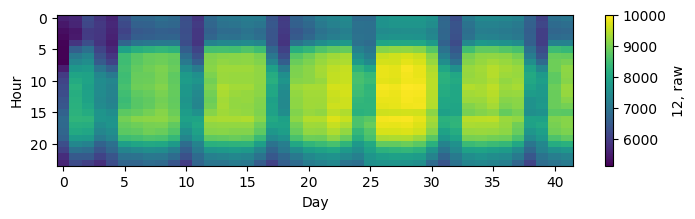

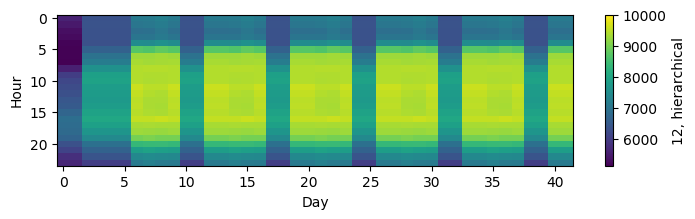

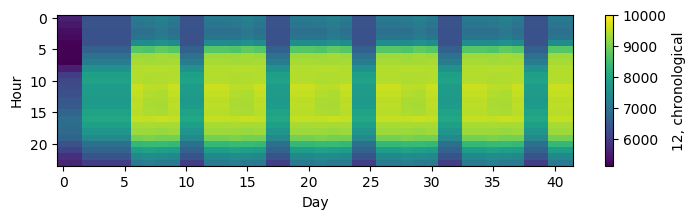

In [63]:
param = '12'
def plotTS(data, periodlength, vmin, vmax, label = 'T [°C]'):
    fig, axes = plt.subplots(figsize = [6, 2], dpi = 100, nrows = 1, ncols = 1)
    stacked, timeindex = unstackToPeriods(copy.deepcopy(data), periodlength)
    cax = axes.imshow(stacked.values.T, interpolation = 'nearest', vmin = vmin, vmax = vmax)
    axes.set_aspect('auto')  
    axes.set_ylabel('Hour')
    plt.xlabel('Day')
    fig.subplots_adjust(right = 1.2)
    cbar=plt.colorbar(cax)    
    cbar.set_label(label)

plotTS(timeseries_df[param], 24, vmin = timeseries_df[param].min(), vmax = timeseries_df[param].max(), label = param + ", raw"
)
plotTS(timeseries_hier[param], 24, vmin = timeseries_df[param].min(), vmax = timeseries_df[param].max(), label = param + ", hierarchical"
)
plotTS(timeseries_chron[param], 24, vmin = timeseries_df[param].min(), vmax = timeseries_df[param].max(), label = param + ", chronological"
)